# Transformada de Fourier
## Procesamiento Digital de Señales

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft

from labs.transformada_fourier import (
    TransformadaFourier,
    generar_señales_test,
    calcular_snr,
    aplicar_ruido,
)

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Fundamentos Teóricos

### Transformada Discreta de Fourier (DFT)

La DFT de una señal discreta $x[n]$ de $N$ muestras se define como:

$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j2\pi kn/N}, \quad k = 0, 1, ..., N-1$$

### Transformada Inversa (IDFT)

$$x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] e^{j2\pi kn/N}, \quad n = 0, 1, ..., N-1$$

### Propiedades importantes:
- **Linealidad**: $\mathcal{F}\{ax[n] + by[n]\} = aX[k] + bY[k]$
- **Periodicidad**: $X[k+N] = X[k]$
- **Simetría**: Para señales reales, $X[N-k] = X^*[k]$
- **Teorema de Parseval**: $\sum_{n=0}^{N-1} |x[n]|^2 = \frac{1}{N} \sum_{k=0}^{N-1} |X[k]|^2$

## 2. Implementación y Comparación: DFT vs FFT

Error máximo entre DFT y FFT: 2.59e-13


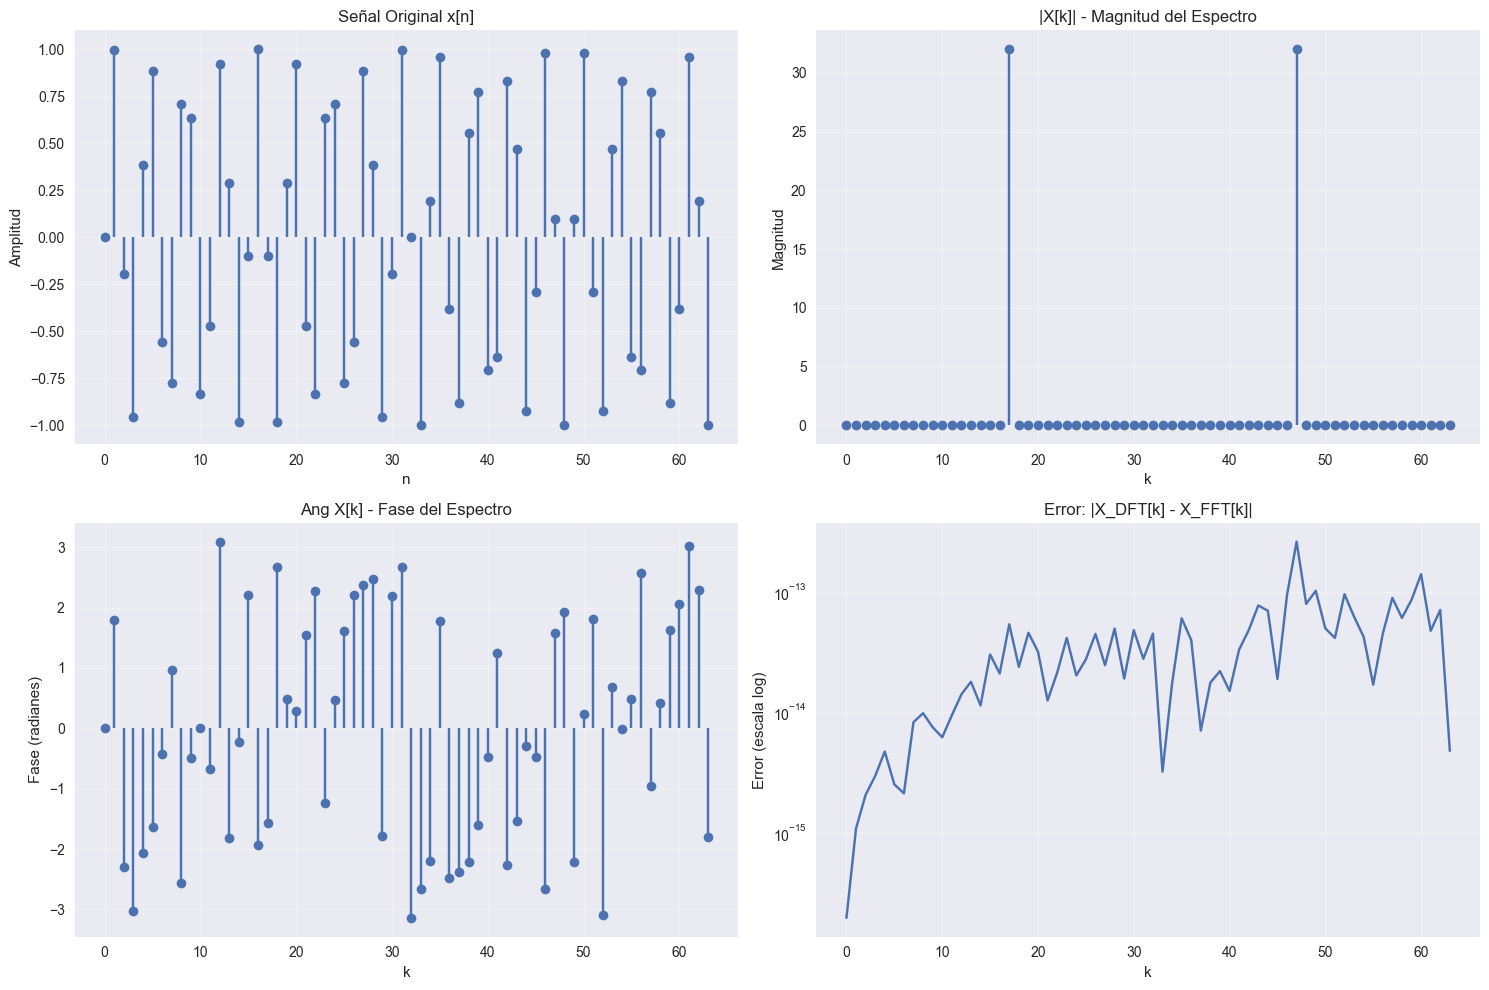

Error de reconstrucción IDFT: 1.32e-14


In [5]:
tf = TransformadaFourier(fs=1000)

N = 64
n = np.arange(N)
f0 = 17
x = np.sin(2 * np.pi * f0 * n / N) # w = 2πf0/N

X_dft = tf.dft(x)
X_fft = fft(x)

error = np.max(np.abs(X_dft - X_fft))
print(f"Error máximo entre DFT y FFT: {error:.2e}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].stem(n, x, basefmt=" ")
axes[0,0].set_title('Señal Original x[n]')
axes[0,0].set_xlabel('n')
axes[0,0].set_ylabel('Amplitud')
axes[0,0].grid(True, alpha=0.3)

k = np.arange(N)
axes[0,1].stem(k, np.abs(X_fft), basefmt=" ")
axes[0,1].set_title('|X[k]| - Magnitud del Espectro')
axes[0,1].set_xlabel('k')
axes[0,1].set_ylabel('Magnitud')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].stem(k, np.angle(X_fft), basefmt=" ")
axes[1,0].set_title('Ang X[k] - Fase del Espectro')
axes[1,0].set_xlabel('k')
axes[1,0].set_ylabel('Fase (radianes)')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].semilogy(k, np.abs(X_dft - X_fft) + 1e-16)
axes[1,1].set_title('Error: |X_DFT[k] - X_FFT[k]|')
axes[1,1].set_xlabel('k')
axes[1,1].set_ylabel('Error (escala log)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

x_reconstruida = tf.idft(X_dft)
error_reconstruccion = np.max(np.abs(x - np.real(x_reconstruida)))
print(f"Error de reconstrucción IDFT: {error_reconstruccion:.2e}")

## 3. Comparación de Rendimiento DFT vs FFT

Comparación DFT vs FFT:
N		DFT (s)		FFT (s)		Speedup
--------------------------------------------------
16		0.000277	0.000136	2.0x
32		0.001064	0.000020	53.1x
64		0.003860	0.000011	352.0x
128		0.028089	0.000095	296.0x
256		0.051364	0.000055	932.6x
512		0.188594	0.000062	3042.4x
1024		0.750949	0.000073	10293.2x


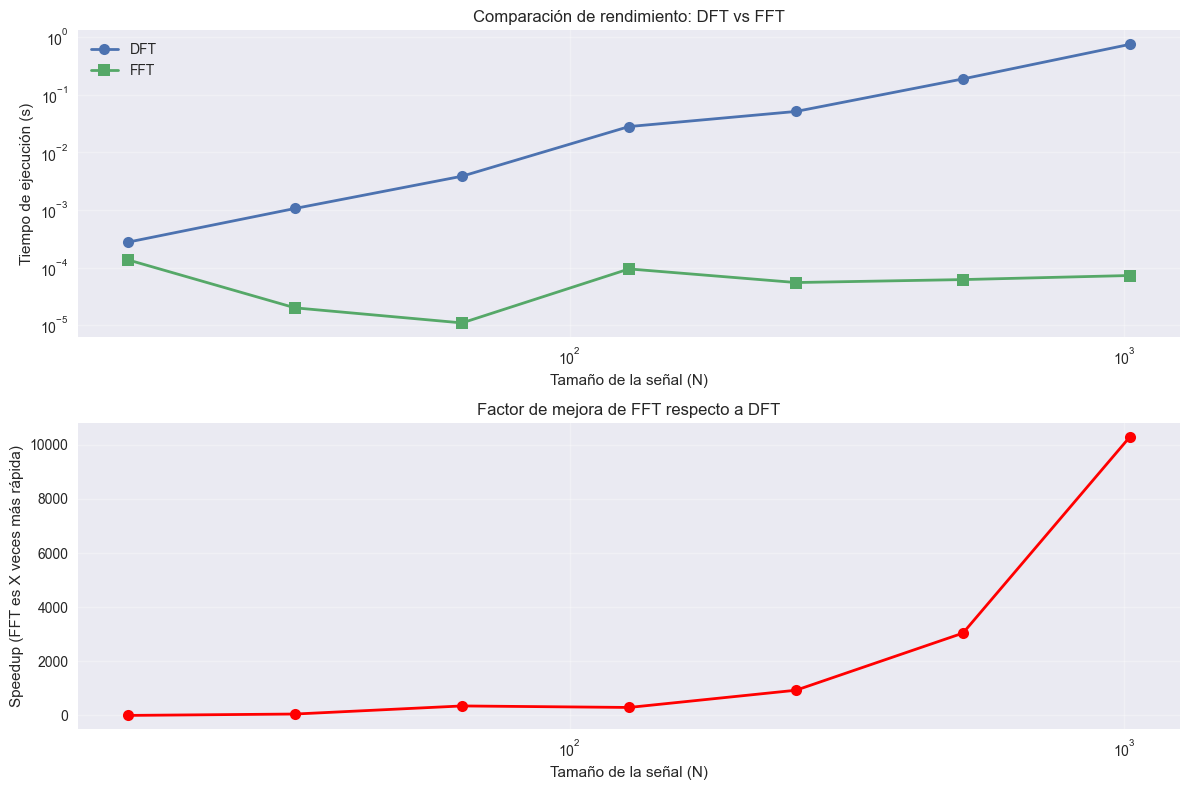


Análisis de Complejidad:
DFT:  O(N²) - Crece cuadráticamente
FFT:  O(N log N) - Crece casi linealmente

Para N=1024:
DFT teórico: 1,048,576 operaciones
FFT teórico: 10,240 operaciones
Speedup teórico: 102.4x


In [6]:
import time

def comparar_rendimiento_dft_fft(N_max=512):
    tamanos = [2**i for i in range(4, int(np.log2(N_max)) + 1)]
    tiempos_dft = []
    tiempos_fft = []

    print("Comparación DFT vs FFT:")
    print("N\t\tDFT (s)\t\tFFT (s)\t\tSpeedup")
    print("-" * 50)

    for N in tamanos:
        x = np.random.randn(N)

        if N <= N_max:
            start = time.time()
            X_dft = tf.dft(x)
            tiempo_dft = time.time() - start
            tiempos_dft.append(tiempo_dft)
        else:
            tiempo_dft = None
            tiempos_dft.append(None)

        start = time.time()
        X_fft = fft(x)
        tiempo_fft = time.time() - start
        tiempos_fft.append(tiempo_fft)

        if tiempo_dft is not None:
            speedup = tiempo_dft / tiempo_fft
            print(f"{N}\t\t{tiempo_dft:.6f}\t{tiempo_fft:.6f}\t{speedup:.1f}x")
        else:
            print(f"{N}\t\t---\t\t{tiempo_fft:.6f}\t---")

    return tamanos, tiempos_dft, tiempos_fft

tamaños, tiempos_dft, tiempos_fft = comparar_rendimiento_dft_fft(N_max=1024)

plt.figure(figsize=(12, 8))

tamaños_dft_validos = []
tiempos_dft_validos = []
for i, tiempo in enumerate(tiempos_dft):
    if tiempo is not None:
        tamaños_dft_validos.append(tamaños[i])
        tiempos_dft_validos.append(tiempo)

plt.subplot(2, 1, 1)
plt.loglog(tamaños_dft_validos, tiempos_dft_validos, 'o-',
           label='DFT', linewidth=2, markersize=8)
plt.loglog(tamaños, tiempos_fft, 's-',
           label='FFT', linewidth=2, markersize=8)
plt.xlabel('Tamaño de la señal (N)')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Comparación de rendimiento: DFT vs FFT')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
speedups = []
for i in range(len(tamaños_dft_validos)):
    idx = tamaños.index(tamaños_dft_validos[i])
    speedup = tiempos_dft_validos[i] / tiempos_fft[idx]
    speedups.append(speedup)

plt.semilogx(tamaños_dft_validos, speedups, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Tamaño de la señal (N)')
plt.ylabel('Speedup (FFT es X veces más rápida)')
plt.title('Factor de mejora de FFT respecto a DFT')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAnálisis de Complejidad:")
print("DFT:  O(N²) - Crece cuadráticamente")
print("FFT:  O(N log N) - Crece casi linealmente")
print(f"\nPara N=1024:")
print(f"DFT teórico: {1024**2:,} operaciones")
print(f"FFT teórico: {int(1024 * np.log2(1024)):,} operaciones")
print(f"Speedup teórico: {1024**2 / (1024 * np.log2(1024)):.1f}x")

## 4. Análisis Espectral de Señales

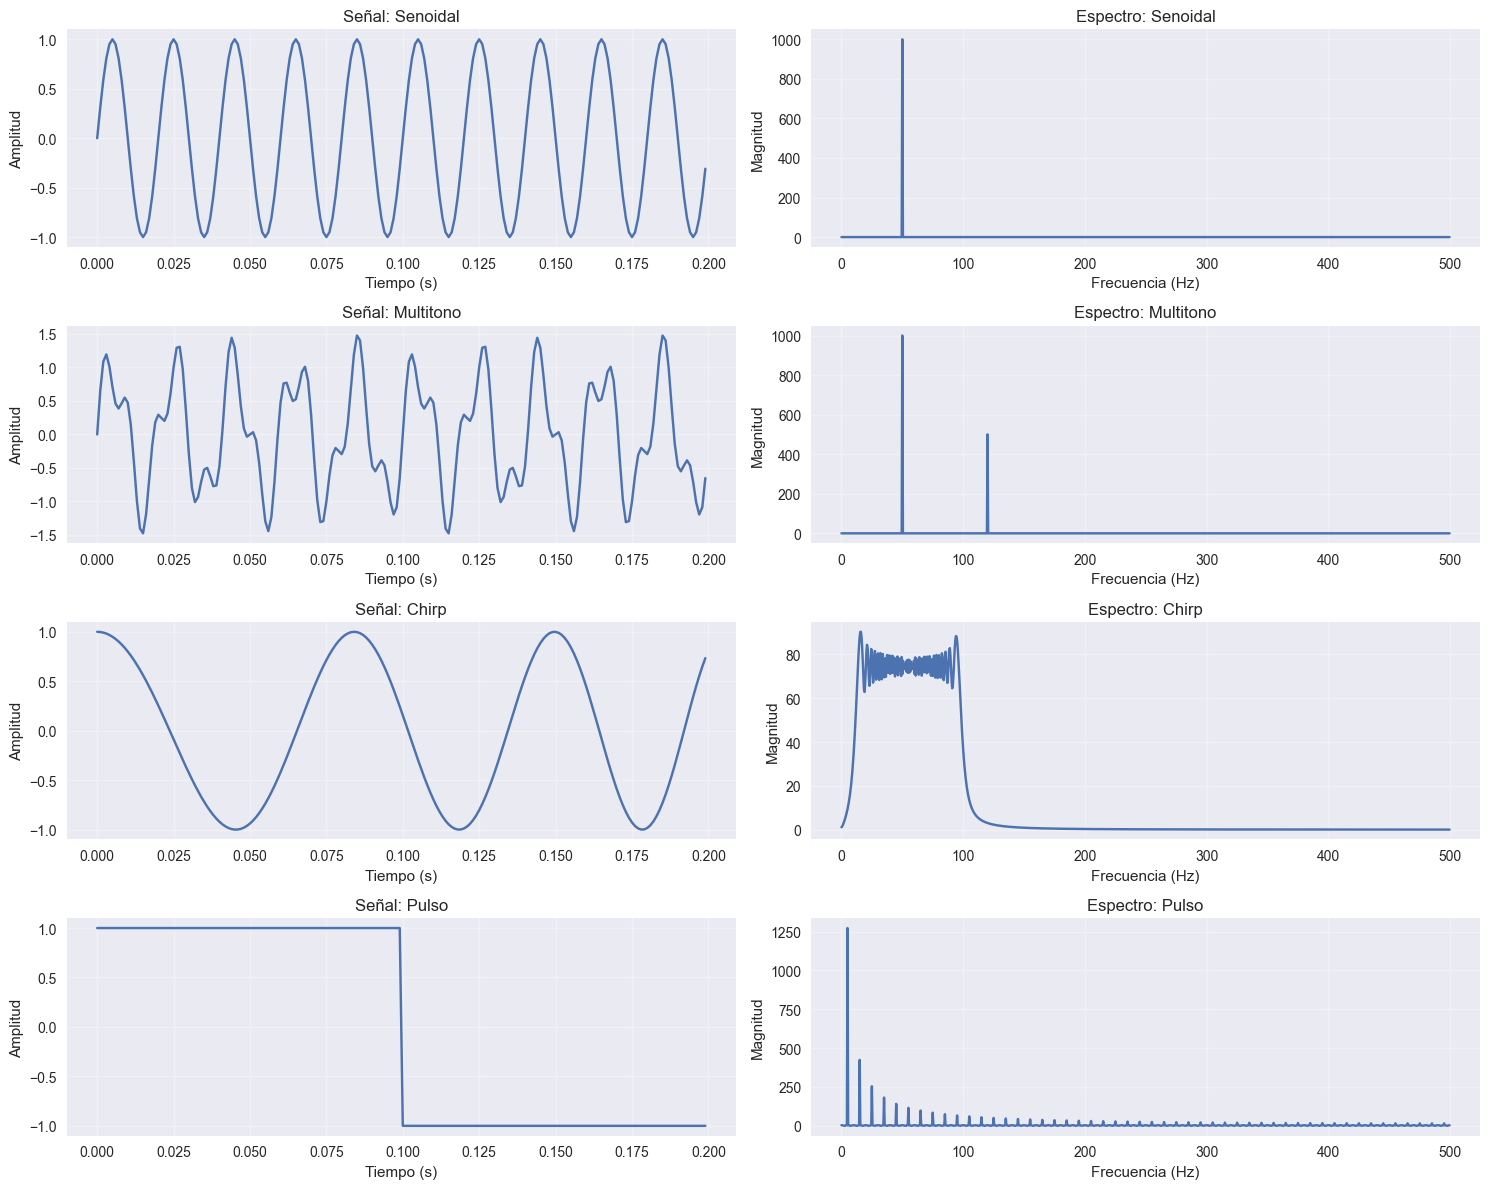

In [5]:
fs = 1000
duracion = 2.0
t, senales = generar_señales_test(fs, duracion)

tf = TransformadaFourier(fs)

nombres = ['senoidal', 'multitono', 'chirp', 'pulso']

fig, axes = plt.subplots(len(nombres), 2, figsize=(15, 12))

for i, nombre in enumerate(nombres):
    x = senales[nombre]

    idx_tiempo = int(0.2 * fs)
    axes[i,0].plot(t[:idx_tiempo], x[:idx_tiempo])
    axes[i,0].set_title(f'Señal: {nombre.capitalize()}')
    axes[i,0].set_xlabel('Tiempo (s)')
    axes[i,0].set_ylabel('Amplitud')
    axes[i,0].grid(True, alpha=0.3)

    freqs, magnitud, _ = tf.fft_analysis(x)

    idx_pos = (freqs >= 0) & (freqs <= fs/2)

    axes[i,1].plot(freqs[idx_pos], magnitud[idx_pos])
    axes[i,1].set_title(f'Espectro: {nombre.capitalize()}')
    axes[i,1].set_xlabel('Frecuencia (Hz)')
    axes[i,1].set_ylabel('Magnitud')
    axes[i,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Convolución y Correlación usando FFT

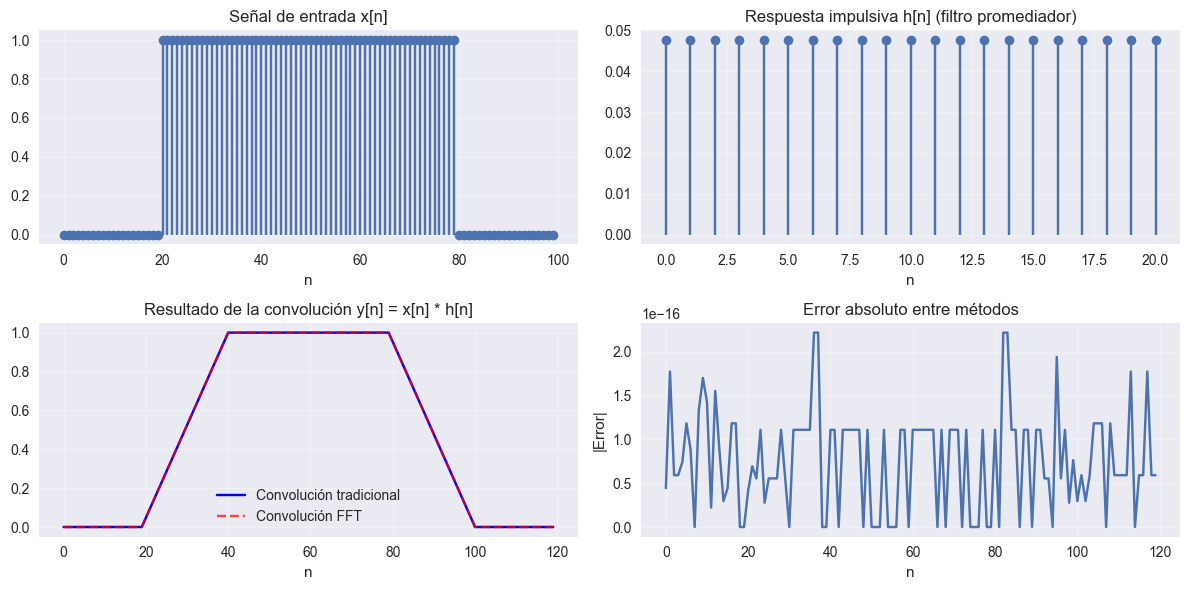

In [14]:
fs = 1000

N1 = 100
x = np.concatenate([np.zeros(20), np.ones(60), np.zeros(20)])

N2 = 21
h = np.ones(N2) / N2

y_conv = np.convolve(x, h, mode='full')
y_fft = tf.convolucion_fft(x, h)

error_conv = np.max(np.abs(y_conv - y_fft))

template = np.array([1, 2, 3, 2, 1])
senal_larga = np.concatenate([np.random.randn(50), template, np.random.randn(30),
                             0.8*template, np.random.randn(40)])

correlacion = tf.correlacion_fft(senal_larga, template)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

n_x = np.arange(len(x))
n_h = np.arange(len(h))
n_y = np.arange(len(y_conv))

axes[0,0].stem(n_x, x, basefmt=" ")
axes[0,0].set_title('Señal de entrada x[n]')
axes[0,0].set_xlabel('n')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].stem(n_h, h, basefmt=" ")
axes[0,1].set_title('Respuesta impulsiva h[n] (filtro promediador)')
axes[0,1].set_xlabel('n')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(n_y, y_conv, 'b-', label='Convolución tradicional')
axes[1,0].plot(n_y, y_fft, 'r--', alpha=0.7, label='Convolución FFT')
axes[1,0].set_title('Resultado de la convolución y[n] = x[n] * h[n]')
axes[1,0].set_xlabel('n')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(n_y, np.abs(y_conv - y_fft))
axes[1,1].set_title('Error absoluto entre métodos')
axes[1,1].set_xlabel('n')
axes[1,1].set_ylabel('|Error|')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()